Downloaded a simple marketing campaign data with experiment and control group for A/B testing

Find answer to following questions:
1. Would the campaign be successful?
2. If the campaign was successful, how much of that success will be attributed to ads.

Data description and downloadable from kaggle: 'https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data'

In [1]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
marketing_data = pandas.read_csv('../data/marketing_AB.csv.zip', compression='zip')

In [3]:
marketing_data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
# Drop Unnamed column
marketing_data = marketing_data.drop(columns=['Unnamed: 0'])
marketing_data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [5]:
# Check data types in each column
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [6]:
# Get summary statistics
marketing_data.describe()

,user id,total ads,most ads hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


In [7]:
# Get summary statistics per group
marketing_data.groupby('test group')['total ads'].describe()

,count,mean,std,min,25%,50%,75%,max
test group,,,,,,,,
ad,564577.0,24.823365,43.750456,1.0,4.0,13.0,27.0,2065.0
psa,23524.0,24.761138,42.860720,1.0,4.0,12.0,26.0,907.0


In [8]:
marketing_data.groupby('test group')['most ads hour'].describe()

,count,mean,std,min,25%,50%,75%,max
test group,,,,,,,,
ad,564577.0,14.475900,4.841808,0.0,11.0,14.0,18.0,23.0
psa,23524.0,14.304923,4.656239,0.0,11.0,14.0,18.0,23.0


In [9]:
# Check for missing values
marketing_data.isnull().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

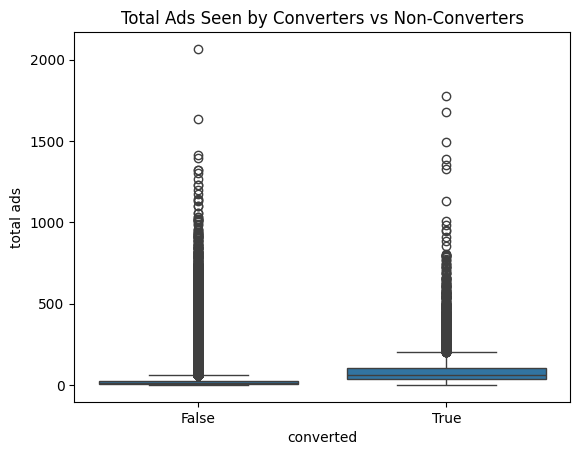

In [10]:
# Check ads seen by converters vs non-converters
sns.boxplot(x='converted', y='total ads', data=marketing_data)
plt.title('Total Ads Seen by Converters vs Non-Converters')
plt.show()

In [11]:
# Get summary statistics for Ads seen by converters vs non-converters
marketing_data.groupby('converted')['total ads'].describe()

,count,mean,std,min,25%,50%,75%,max
converted,,,,,,,,
False,573258.0,23.291495,40.863176,1.0,4.0,13.0,26.0,2065.0
True,14843.0,83.887759,87.455498,1.0,35.0,64.0,103.0,1778.0


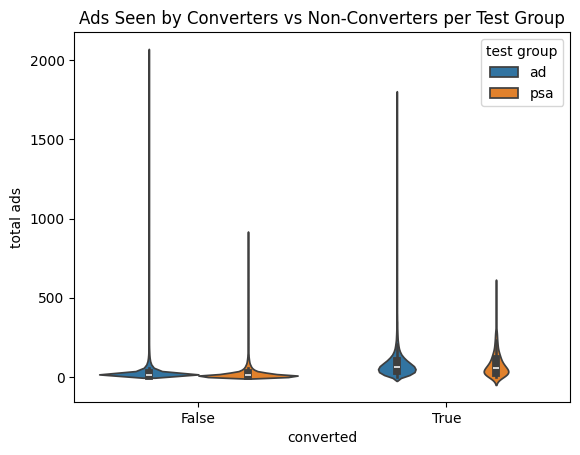

In [12]:
# Check Ads seen by converters vs non-converters per test group
sns.violinplot(x='converted', y='total ads', hue='test group', data=marketing_data)
plt.title('Ads Seen by Converters vs Non-Converters per Test Group')
plt.show()

### Detect Outliers using Inter-quartile range (IQR)

In [13]:
def get_outliers_iqr(data):
    # Get 25th and 75th percentiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate IQR and bounds
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

In [14]:
filter_outliers = get_outliers_iqr(marketing_data['total ads'])
print("Total outliers in 'total ads':\n", len(filter_outliers))
print("Percentage of outliers: {:.2f}%".format((len(filter_outliers) / len(marketing_data)) * 100))

Total outliers in 'total ads':
 52057
Percentage of outliers: 8.85%


In [15]:
# separate outliers from non-outliers
outliers_data = marketing_data[marketing_data['total ads'].isin(filter_outliers)]
non_outliers_data = marketing_data[~marketing_data['total ads'].isin(filter_outliers)]

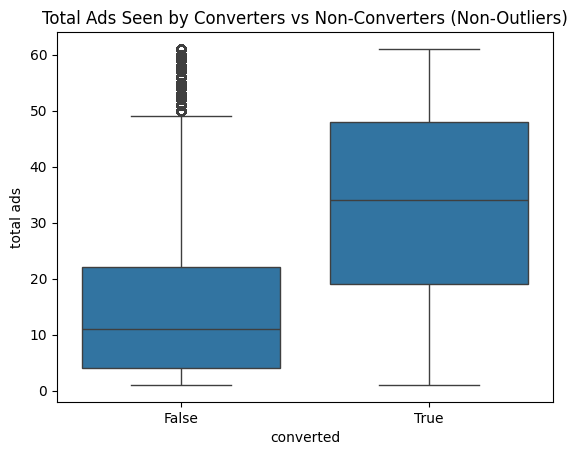

In [16]:
# Check ads seen by converters vs non-converters for non-outliers
sns.boxplot(x='converted', y='total ads', data=non_outliers_data)
plt.title('Total Ads Seen by Converters vs Non-Converters (Non-Outliers)')
plt.show()

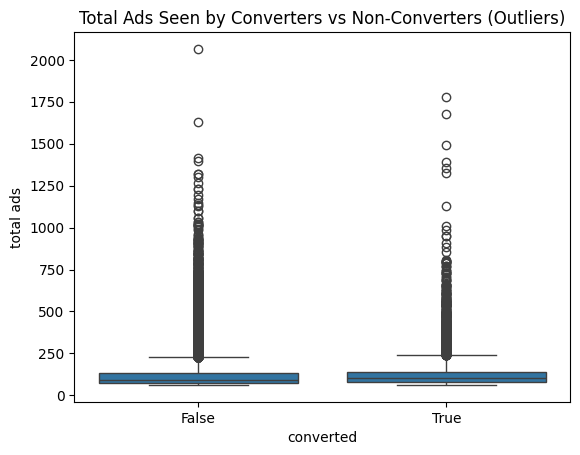

In [17]:
# Check ads seen by converters vs non-converters for outliers
sns.boxplot(x='converted', y='total ads', data=outliers_data)
plt.title('Total Ads Seen by Converters vs Non-Converters (Outliers)')
plt.show()

There is a clear difference in total ads viewed by converters vs non-converters in non-outlier samples.

### Summary statistics for Non-outlier samples

In [18]:
# Summary statistics for Ads seen by converters vs non-converters per test group
non_outliers_data['converted'] = non_outliers_data['converted'].astype(int)
summary_a_b_testing = non_outliers_data.groupby("test group")["converted"]\
    .agg(['mean', 'count', 'sum', 'std'])\
    .rename(columns={'mean':'conversion_rate', 'sum':'total_conversions', 'count':'users'})
summary_a_b_testing['conversion_rate'] = summary_a_b_testing['conversion_rate'] * 100

/tmp/ipykernel_9989/1800033436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_data['converted'] = non_outliers_data['converted'].astype(int)


In [19]:
print("\nA/B Testing Summary Statistics (Non-outliers):\n", summary_a_b_testing)


A/B Testing Summary Statistics (Non-outliers):
             conversion_rate   users  total_conversions       std
test group                                                      
ad                 1.338408  514716               6889  0.114913
psa                1.059640   21328                226  0.102394


In [20]:
# Lets check summary statistics when outliers are included
marketing_data['converted'] = marketing_data['converted'].astype(int)
summary_a_b_testing_full = marketing_data.groupby("test group")["converted"]\
    .agg(['mean', 'count', 'sum', 'std'])\
    .rename(columns={'mean':'conversion_rate', 'sum':'total_conversions', 'count':'users'})
summary_a_b_testing_full['conversion_rate'] = summary_a_b_testing_full['conversion_rate'] * 100

In [21]:
print("\nA/B Testing Summary Statistics (All samples):\n", summary_a_b_testing_full)


A/B Testing Summary Statistics (All samples):
             conversion_rate   users  total_conversions       std
test group                                                      
ad                 2.554656  564577              14423  0.157778
psa                1.785411   23524                420  0.132424


### Calculate Absolute lift and Relative lift

Absolute lift describes direct difference between test group's(ada) conversion rate and control group's(psa) conversion rate.

Relative lift tells how much better ad group performed in comparison to control group

In [22]:
cr_ad = summary_a_b_testing.loc["ad", "conversion_rate"] / 100
cr_psa = summary_a_b_testing.loc["psa", "conversion_rate"] / 100

In [23]:
absolute_lift = cr_ad - cr_psa
relative_lift = (cr_ad - cr_psa) / cr_psa * 100

In [24]:
print(f"\nAbsolute Lift: {absolute_lift:.4f}%")
print(f"Relative Lift: {relative_lift:.2f}%")


Absolute Lift: 0.0028%
Relative Lift: 26.31%


In [25]:
# Check Absolute and Relative lift when outliers are included
cr_ad_full = summary_a_b_testing_full.loc["ad", "conversion_rate"] / 100
cr_psa_full = summary_a_b_testing_full.loc["psa", "conversion_rate"] / 100  
absolute_lift_full = cr_ad_full - cr_psa_full
relative_lift_full = (cr_ad_full - cr_psa_full) / cr_psa_full * 100
print(f"\nAbsolute Lift (All samples): {absolute_lift_full:.4f}%")
print(f"Relative Lift (All samples): {relative_lift_full:.2f}%")


Absolute Lift (All samples): 0.0077%
Relative Lift (All samples): 43.09%


### The absolute and relative lift with all the samples (including outliers) is higher when compared with samples without outliers. 
This may indicate following:
- Outliers are helping treatment group more than control group.
- Either they truely respond to more ads or are imbalanced by chance.
- The metric is skewed and sensitive to extreme values.
- A/B test becomes less stable and less trustworthy.
- Check if outliers represent real user behaivour.

Let's do following:
- Identify outliers using 99th percentile
- Check whether outliers are imbalanced across groups

In [26]:
# Identify outlier threshold for total ads(or any continuous metric)
threshold = marketing_data['total ads'].quantile(0.99)

# Flag outliers
marketing_data['is_outlier'] = marketing_data['total ads'] > threshold

print("Outlier threshold:", threshold)
marketing_data['is_outlier'].value_counts()

Outlier threshold: 202.0


is_outlier
False    582291
True       5810
Name: count, dtype: int64

In [27]:
# Check whether outliers are imbalanced across test groups
outlier_dist = marketing_data.groupby(['test group', 'is_outlier'])['total ads'].count().unstack(fill_value=0)
print(outlier_dist)

# Percentage of outliers in each group
outlier_pct = marketing_data.groupby('test group')['is_outlier'].mean() * 100
print("\nOutlier percentage by group (%):")
print(outlier_pct)

is_outlier   False  True 
test group               
ad          559017   5560
psa          23274    250

Outlier percentage by group (%):
test group
ad     0.984808
psa    1.062744
Name: is_outlier, dtype: float64


Outlier percentage is nearly same in both groups. There is no significant imbalance.

### Get confidence intervals for each group

Confidence intervals show the uncertainty of the estimate and help determine if groups are meanigfully different. If CIs of two groups do not overlap, the difference is likely significant. 

In [28]:
ci_ad = proportion_confint(summary_a_b_testing.loc["ad", "total_conversions"], 
                           summary_a_b_testing.loc["ad", "users"], 
                           method='wilson')
ci_psa = proportion_confint(summary_a_b_testing.loc["psa", "total_conversions"], 
                            summary_a_b_testing.loc["psa", "users"], 
                            method='wilson')

In [29]:
print("\n=== 95% CI for Conversion Rates ===")
print(f"Ad group     CI: {ci_ad}")
print(f"PSA group    CI: {ci_psa}")


=== 95% CI for Conversion Rates ===
Ad group     CI: (0.013073761820752747, 0.013701661135083101)
PSA group    CI: (0.00930766644881147, 0.012061396306537485)


CIs of the two groups do not overlap, this suggests difference is likely significant and there is strong evidence that campaign changes conversion

### Statistical significance test with Z-test and power analysis.

Power analysis can be done to answer whether enough sample size is present to detect the lift.

It estimates statistical power given:
- baseline conversion rate
- minimum detectable effect (MDE)
- sample size per group
- significance level 
- test-type

In [33]:
n_ad = marketing_data[marketing_data['test group'] == 'ad'].shape[0]
n_psa = marketing_data[marketing_data['test group'] == 'psa'].shape[0]
print(f"Sample sizes - Ad group: {n_ad}, PSA group: {n_psa}")

Sample sizes - Ad group: 564577, PSA group: 23524


In [34]:
# Compute effect size for the two proportions
from statsmodels.stats.proportion import proportion_effectsize
effect = proportion_effectsize(cr_ad_full, cr_psa_full)

print(f"Effect size (Cohen's h): {effect:.4f}")

Effect size (Cohen's h): 0.0530


In [35]:
# Power analysis for sample size determination
from statsmodels.stats.power import NormalIndPower
power_analysis = NormalIndPower()
power = power_analysis.power(effect_size=effect,
                             nobs1=n_ad,
                             alpha=0.05,
                             ratio=n_psa/n_ad)
print(f"Statistical Power: {power:.4f}")

Statistical Power: 1.0000


Since Statistical Power is > 0.8 --> experiment is sufficiently powered

In [36]:
# Compute required sample size for desired MDE. Suppose we want to detect a 0.5% lift:
mde = 0.005  # 0.5% lift
baseline_cr = cr_psa_full
variant_cr = baseline_cr + mde
effect_size = proportion_effectsize(baseline_cr, variant_cr)
required_n = power_analysis.solve_power(effect_size=effect_size,
                                        power=0.8,
                                        alpha=0.05,
                                        ratio=1)
print(f"Required sample size per group to detect {mde*100:.2f}% lift with 80% power: {required_n:.0f}")

Required sample size per group to detect 0.50% lift with 80% power: 12474


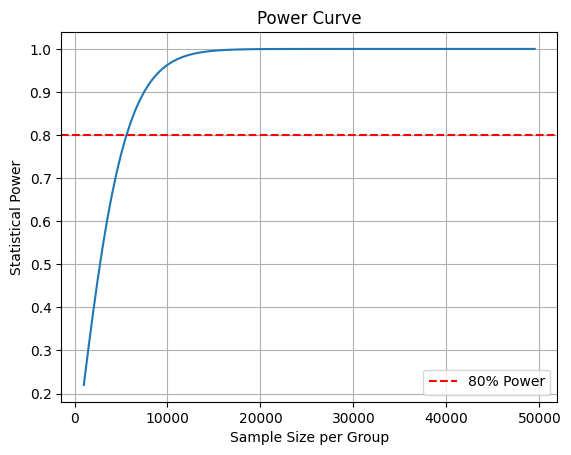

In [37]:
# Plot power curve
sample_sizes = np.arange(1000, 50000, 500)
powers = [power_analysis.power(effect_size=effect,
                              nobs1=i,
                              alpha=0.05,
                              ratio=1) for i in sample_sizes]

plt.plot(sample_sizes, powers)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Power')
plt.title('Power Curve')
plt.xlabel('Sample Size per Group')
plt.ylabel('Statistical Power')
plt.legend()
plt.grid()
plt.show()

We have sufficient samples in the two groups to detect a 0.5% lift

Statistical test (Z-test)

In [38]:
count = np.array([summary_a_b_testing_full.loc["ad","total_conversions"], 
                  summary_a_b_testing_full.loc["psa","total_conversions"]])
nobs = np.array([summary_a_b_testing_full.loc["ad","users"], 
                 summary_a_b_testing_full.loc["psa","users"]])

In [39]:
z_stat, p_value = proportions_ztest(count, nobs)

In [40]:
print("\n=== Z-test for difference in proportions ===")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value:     {p_value:.6f}")

if p_value < 0.05:
    print("Result: ❗ Statistically significant difference (reject H0)")
else:
    print("Result: ❌ No statistically significant difference")


=== Z-test for difference in proportions ===
Z-statistic: 7.3701
P-value:     0.000000
Result: ❗ Statistically significant difference (reject H0)


### Bootstrap confidence interval for lift

Random re-sampling of observed data is performed to ensure robust, data-driven estimate of uncertainty for difference in conversion rates between test and control groups. Advantage of bootstraping:
- Unlike Z-test, it doesn't assume normally distributed metric.
- Bootstrap also works when sample size is small.
- Instead of computing separate CIs for each group and guessing overlap, bootstrap gives a CI for the difference itself
- If conversions are rare (e.g., 1–2%), standard parametric approximations may be inaccurate; bootstrap is more reliable.

In [34]:
def bootstrap_lift(data, group_col, outcome_col, n_boot=5000):
    rng = np.random.default_rng(42)
    diffs = []
    for _ in range(n_boot):
        sample = data.sample(frac=1, replace=True, random_state=rng.integers(1e9))
        cr_ad = sample.loc[sample[group_col]=='ad', outcome_col].mean()
        cr_psa = sample.loc[sample[group_col]=='psa', outcome_col].mean()
        diffs.append(cr_ad - cr_psa)
    return np.percentile(diffs, [2.5, 97.5])

In [35]:
boot_ci_low, boot_ci_high = bootstrap_lift(marketing_data, "test group", "converted")
print("\n=== Bootstrap 95% CI for Lift ===")
print(f"Lift CI: [{boot_ci_low:.4%}, {boot_ci_high:.4%}]")


=== Bootstrap 95% CI for Lift ===
Lift CI: [0.5936%, 0.9387%]


The CI tells us that, based on data and bootstrap resampling, the true lift is likely between 0.5936% and 0.9387%. Since the entire CI is above 0, this suggests that the Ad campaign has a statistically significant positive effect. Even though the lift is statistically significant, the magnitude is less than 1%. 

If ads is shown to 10,000 users:

Extra conversions = 10,000 * 0.005936 ≈ 59 to 10,000 * 0.009387 ≈ 94 conversions

If average order value (AOV) is 50$:

Estimated revenue lift = 59 * 50 ≈ $2,950 to 94 * 50 ≈ $4,685

So the campaign produces modest but positive revenue impact.